<a href="https://colab.research.google.com/github/gabrielfernandorey/ITBA-NLP/blob/main/ITBA_nlp01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

## Merged models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from datetime import datetime, date
from dateutil.parser import parse
from dotenv import load_dotenv

from NLP_tools import *

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [3]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import *
from opensearchpy import helpers

from openai import OpenAI

### Inicializamos la base vectorial

In [4]:
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Path

In [5]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [6]:
if PATH == os.environ.get('PATH_LOCAL'):
    if os.environ.get('OPENAI_API_KEY'):
        client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
    else:
        client = None
    print(client)

### Cargamos noticias 
- Notas:
    - Se carga el segundo batch de noticias, luego de haber corrido al menos el primero y segundo batch con la notebook NLP_01_data
    - Se debe haber generado el primer modelo en NLP_02_model
    - Para cargar el segundo batch, se utiliza la fecha como identificador del lote

In [150]:
# Cargar batch de noticias ( a partir del segundo batch en adelante ) por fecha previamente preprocesado en NLP_01_data 
choice = "20240718"  
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]
batch_news = get_news(date_choice)

if batch_news == []:
    print("No hay noticias a procesar")

id_data     = [reg[0] for reg in batch_news]
title_data  = [reg[1] for reg in batch_news]
news_data   = [reg[2] for reg in batch_news]
keywords    = [reg[3] for reg in batch_news]
entities    = [reg[4] for reg in batch_news]
created     = [reg[5] for reg in batch_news]

# Cargar vocabulario previamente procesado
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

4000

### Preprocesar batch de noticias

In [151]:
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

clean_data = Cleaning_text()

proc_data = []
for data_in in tqdm(news_data):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 1205.33it/s]


### Modelo para el batch

In [152]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(news_data)

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model_2 = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Entrenamiento

In [153]:
# Entrenamiento
_, _ = topic_model_2.fit_transform(proc_data)

# No necesito generar topicos, ni probabilidades, ni embeddings del modelo 2, ya que vamos a fusionar modelos.

2024-08-28 13:09:45,639 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-08-28 13:10:35,881 - BERTopic - Embedding - Completed ✓
2024-08-28 13:10:35,883 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-28 13:10:41,666 - BERTopic - Dimensionality - Completed ✓
2024-08-28 13:10:41,668 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-28 13:10:41,721 - BERTopic - Cluster - Completed ✓
2024-08-28 13:10:41,729 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-28 13:10:42,631 - BERTopic - Representation - Completed ✓


### Merge de modelos

In [154]:
# Cargamos el modelo anterior
topic_model_1 = BERTopic.load(PATH+"modelos_notebook/bertopic_model_last")
print(f"Topicos anteriores: {len(set(topic_model_1.get_topics().keys()))-1}")

Topicos anteriores: 12


In [155]:
# Combinar los modelos en uno solo
merged_model = BERTopic.merge_models([topic_model_1, topic_model_2])

In [156]:
# Grabar modelo fusionado
merged_model.save(PATH+f"modelos_notebook/bertopic_model_last")

2024-08-28 13:10:49,741 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [157]:
print(f"Cantidad de tópicos modelo 1: {len(topic_model_1.get_topic_info())} -- del 0 al {len(topic_model_1.get_topic_info())-1} (incluye topico -1)")
print(f"Cantidad de tópicos modelo 2: {len(topic_model_2.get_topic_info())} -- del 0 al {len(topic_model_2.get_topic_info())-1} (incluye topico -1)")
print(f"Cantidad de tópicos modelo merge: {len(merged_model.get_topic_info())} -- del 0 al {len(merged_model.get_topic_info())-1} (incluye topico -1)")

Cantidad de tópicos modelo 1: 13 -- del 0 al 12 (incluye topico -1)
Cantidad de tópicos modelo 2: 14 -- del 0 al 13 (incluye topico -1)
Cantidad de tópicos modelo merge: 15 -- del 0 al 14 (incluye topico -1)


In [158]:
# Armar set de datos para inferir (ya procesados y nuevos)
news_data_1 = get_news( process=True )
df_news_1 = pd.DataFrame(news_data_1 , columns=["indice", "titulo", "noticia", "keywords", "entidades", "creado", "pos_id"])
df_news_1.sort_values("pos_id", ascending=True, inplace=True)

news_data_2 = {"indice":id_data, "titulo":title_data, "noticia":news_data, "keywords":keywords, "entidades":entities, "creado":created}
df_news_2 = pd.DataFrame(news_data_2)

df_unificado = pd.concat([df_news_1, df_news_2], ignore_index=True)

In [159]:
# Listas de atributos de datos unificados
u_id_data      = list(df_unificado['indice'])
u_title_data   = list(df_unificado['titulo'])
u_data         = list(df_unificado['noticia'])

In [160]:
# Topicos validos (quitamos el topico -1)
topics_to_save = list(merged_model.get_topics().keys())[1:]
len(topics_to_save)

14

In [161]:
# Visualizar cantidad de documentos que aportan a los topicos el modelo anterior, el modelo fusionado, y el total de ambos
df_combined = merged_results(topic_model_1, merged_model)
print(df_combined)

    Topic  Count1  Count2  Merged
0      -1   514.0   195.0     709
1       0   241.0   109.0     350
2       1    73.0    81.0     154
3       2    36.0    20.0      56
4       3    29.0    12.0      41
5       4    19.0    34.0      53
6       5    17.0     0.0      17
7       6    16.0     0.0      16
8       7    12.0     0.0      12
9       8    12.0     0.0      12
10      9    11.0    12.0      23
11     10    10.0     0.0      10
12     11    10.0     0.0      10
13     12     NaN    24.0      24
14     13     NaN    13.0      13


In [162]:
# Topicos modelo merged
merged_model.topic_labels_

{-1: '-1_es_em_años_personas',
 0: '0_años_policía_investigación_familia',
 1: '1_copa_selección_jugadores_jugador',
 2: '2_actividades_vacaciones_visitantes_artistas',
 3: '3_inteligencia_agencia_agencias_amenazas',
 4: '4_merenderos_agua_calle_zona',
 5: '5_ley_reforma laboral_trabajo_trabajadores',
 6: '6_dólar_bitcoin_riesgo país_bonos',
 7: '7_temperatura_precipitaciones_variedades_masa',
 8: '8_caída_toneladas_producción_productores',
 9: '9_copa_dato confiable_quinta pata_temita',
 10: '10_sociedades_sociedades anónimas_clubes_asociaciones civiles',
 11: '11_cementerio_inscriptos_restos_construcción',
 12: '8_atentado_víctimas_edificio_justicia',
 13: '10_inteligencia emocional_emociones_sueño_doctora'}

In [163]:
# Elegir un topico que tenga aporte de noticias al topico por ambos modelos
topic_id = 0
docs_per_topics = [i for i, x in enumerate(merged_model.topics_) if x == topic_id]


print(f"Noticias totales del topico {topic_id}:", len(docs_per_topics))
# Lista de columnas que quieres excluir
columnas_a_excluir = ['noticia', 'keywords','entidades','pos_id']


df_query = df_unificado.loc[docs_per_topics, df_unificado.columns.difference(columnas_a_excluir)]
df_query.style.set_properties(subset=['titulo'], **{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('min-width', '50px')]}, {'selector': 'td', 'props': [('min-width', '140px')]}])

Noticias totales del topico 0: 350


,creado,indice,titulo
0,2024-07-16T03:11:53,114812746,"Magaly Medina arremete contra Paolo Guerrero: ""Mostró su verdadero rostro, berrinchudo. Cree que se apellida Messi"""
5,2024-07-16T05:20:08,114817772,STJ é acionado e vai julgar decisões que validam tese do 'racismo reverso'
10,2024-07-16T17:12:19,114869211,Clausuraron dos locales comerciales en Quilmes tras las quejas de los vecinos
16,2024-07-16T11:55:39,114840415,Conmoción por la trágica muerte del arquero de Barcelona de Ecuador en un accidente doméstico
20,2024-07-16T15:42:28,114864092,Ecuador: defensores de derechos humanos exigen medidas urgentes ante la crisis carcelaria
27,2024-07-16T18:02:18,114873705,Se derrumbó el rancho de un anciano ciego que vive solo en los cerros salteños
28,2024-07-16T13:13:03,114845379,"Jake Gyllenhaal: del drama a la acción, exploramos sus papeles más memorables en diferentes géneros"
37,2024-07-16T13:39:38,114850776,L-Gante sufrió una tremenda caída en un show en Paraguay: El momento capturado por los fanáticos
40,2024-07-16T05:36:34,114819521,Falleció Amelia Sesto de Leiva
54,2024-07-16T05:11:52,114816913,Cristiana Oliveira e Sabrina Petraglia serão mãe e filha em filme sobre o universo da maternidade


### Obtenemos transformaciones y embeddings del batch

In [164]:
topics_batch, probs_batch = merged_model.transform(news_data)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-08-28 13:12:06,049 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [165]:
# Obtenemos embeddings de todos los documentos
docs_embedding_batch = merged_model.embedding_model.embed(news_data)

### Actualizar datos en news 

In [166]:
# Marcar registros de noticias como procesados y grabar sus embeddings, topicos, probs 
update_news( id_data, docs_embedding_batch, topics_batch, probs_batch )

True

### Actualizar en Topicos

In [167]:
# Obtener las fechas desde/hasta de los topicos existentes de opensearch
from_date, to_date = get_topics_date()
from_date, to_date

(['2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00'],
 ['2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00'])

In [168]:
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]

# Preparar fechas para actualizar en los topicos ( excluyendo topico -1)
from_date_to_save, to_date_to_save = update_topics_date(from_date, to_date, df_combined[1:], date_choice)
from_date_to_save, to_date_to_save

(['2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00'],
 ['2024-07-19T00:00:00',
  '2024-07-19T00:00:00',
  '2024-07-19T00:00:00',
  '2024-07-19T00:00:00',
  '2024-07-19T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-19T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-19T00:00:00',
  '2024-07-19T00:00:00'])

In [169]:
# Topicos validos (quitamos el topico -1)
topics_to_save = list(merged_model.get_topics().keys())[1:]

In [170]:
# Obtener los nombres de los tópicos existentes
topics_name = get_topics_opensearch()
topics_name = [name['name'] for name in topics_name]
topics_name


['Crisis económica y agrícola actual',
 'Reestructuración de servicios de inteligencia',
 'Problemas de agua y servicios públicos',
 'Mercados financieros y economía argentina',
 'Actividades culturales en invierno',
 'Temas de actualidad y criminalidad.',
 'Clima y sus efectos agrícolas',
 'Diálogo entre Gobierno y sindicatos',
 'Crisis y cambios en Boca Juniors',
 'Temas variados de actualidad argentina.',
 'Transformación de clubes en SAD',
 'Iniciativas y mejoras comunitarias locales']

In [171]:
# Eliminar topicos existentes
delete_index_opensearch("topic")

# Grabar todos los topicos en la base
for topic_id in merged_model.get_topics().keys():
    
    if topic_id > -1:

        topic_keywords_top  = top_keywords(topic_id, merged_model, PATH)
        topic_entities_top  = get_top_entities_os(topic_id)
        topic_documents_title, threshold  = get_top_documents_threshold(topic_id)
        id_best_doc, title_best_doc, best_doc = best_document(topic_id, merged_model, docs_embedding_batch, u_id_data, u_title_data, u_data)
        
        topic_doc = Topic(
            index = topic_id,
            name = get_topic_name(''.join(topic_documents_title), topic_id, merged_model, client),
            vector = list(merged_model.topic_embeddings_[topic_id + 1 ]),
            similarity_threshold = threshold,
            created_at = parse(from_date[topic_id]),
            from_date = parse(from_date[topic_id]),
            to_date = parse(to_date[topic_id]),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()


Nota: Cada modelo puede representar ordenes distintos de los topicos, pero al fusionarlos, el orden del modelo 1 se mantiene en el fusionado y se agregan los nuevos al final

### Verificacion

#### Temporalidad de los topicos

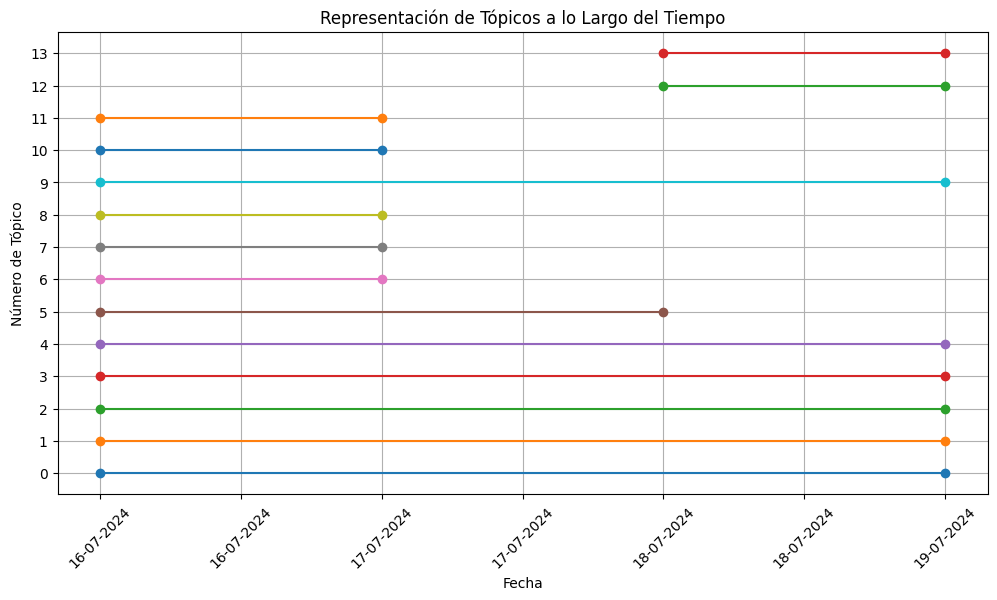

In [172]:
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.pyplot as plt
import pandas as pd

data_plot = {'topic': range(len(merged_model.get_topics().keys())-1),
             'from': from_date_to_save,
             'to': to_date_to_save}

df_plot = pd.DataFrame(data_plot)
df_plot['from'] = pd.to_datetime(df_plot['from'], format='ISO8601')
df_plot['to'] = pd.to_datetime(df_plot['to'], format='ISO8601')

plt.figure(figsize=(12, 6))

for index, row in df_plot.iterrows():
    plt.plot([row['from'], row['to']], [row['topic'], row['topic']], marker='o')

# Formatear las fechas en el eje X
date_form = DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_form)

# Ajustar los ticks del eje X para que no se repitan las fechas
locator = AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

plt.yticks(df_plot['topic'].unique())
plt.xlabel('Fecha')
plt.ylabel('Número de Tópico')
plt.title('Representación de Tópicos a lo Largo del Tiempo')
plt.grid(True)

# Rotar las etiquetas de fecha para mejor legibilidad (opcional)
plt.xticks(rotation=45)

plt.show()


### Panel de Topicos

In [39]:
def panel_topicos(fecha):
    df_topics = pd.DataFrame(get_topics_opensearch(fecha))

    if not df_topics.empty:

        columnas_a_excluir = ['vector', 'created_at', 'best_doc']

        df_query = df_topics[df_topics.columns.difference(columnas_a_excluir)].sort_values("index", ascending=True)
        column_order = ['index','name','from_date', 'to_date', 'similarity_threshold', 'keywords', 'entities', 'id_best_doc', 'title_best_doc']

        df_result = df_query.reindex(columns=column_order).style.set_properties(subset=['name'], **{'text-align': 'left'}).set_table_styles([{'selector': 'th','props': [('min-width', '40px')]},
                                                                                                                                             {'selector': 'td', 'props': [('min-width', '140px')]}])
        
        return df_result
    else:
        print("No hay tópicos para los parámetros elegidos")


In [41]:
fecha = None
fecha = "2024-07-17"
panel_topicos(fecha)

,index,name,from_date,to_date,similarity_threshold,keywords,entities,id_best_doc,title_best_doc
2,6,Inversiones y fluctuaciones del mercado,2024-07-16T00:00:00,2024-07-17T00:00:00,0.546806,"{'dólar': 0.11438482436199902, 'bitcoin': 0.08364270459024674, 'riesgo país': 0.08263818138425844, 'bonos': 0.07249250109139875}","{'Gobierno': 11, 'Banco Central': 9, 'Argentina': 7, 'BCRA': 6, 'Banco Nación': 5, 'Ministerio de Economía': 5, 'CCL': 4, 'Fondo Monetario Internacional': 4, 'Luis Caputo': 4, 'DNDA': 3}",114852125,ANSES: todos los pagos de hoy martes 16 de julio
0,7,Pronóstico del clima en Argentina,2024-07-16T00:00:00,2024-07-17T00:00:00,0.557018,"{'temperatura': 0.09902999278778626, 'precipitaciones': 0.09486188931947562, 'variedades': 0.08892627851942346, 'masa': 0.08707547117182775, 'temperaturas': 0.08563554170409368}","{'Buenos Aires': 4, 'Mendoza': 3, 'Neuquén': 2, 'Pronóstico': 2, 'Río Negro': 2, 'Servicio Meteorológico Nacional': 2, 'Actividades': 1, 'Aemet': 1, 'Alan Ritchson': 1, 'Amarillo': 1}",114838957,"Facundo Manes llamó ""barrabrava digital"" a Javier Milei por polémica sobre Lionel Messi"
1,8,Crisis económica y aumento de precios.,2024-07-16T00:00:00,2024-07-17T00:00:00,0.361007,"{'caída': 0.07640246664967254, 'toneladas': 0.06549919019656607, 'producción': 0.06316077551473723, 'productores': 0.062365272892522874, 'productos': 0.0614932571786918}","{'Argentina': 6, 'Unión Industrial Argentina': 4, 'Bolsa de Cereales': 3, 'Gobierno': 3, 'República Argentina': 3, 'Santa Fe': 3, 'UIA': 3, 'la Argentina': 3, 'Anmat': 2, 'Brasil': 2}",114846634,Piden declarar patrimonio cultural a un castillo bonaerense en peligro de derrumbe
4,10,Transformación de clubes en SAD,2024-07-16T00:00:00,2024-07-17T00:00:00,0.469165,"{'sociedades': 0.1435086555179809, 'sociedades anónimas': 0.13052131485005325, 'clubes': 0.12128001706433471}","{'Sociedades Anónimas Deportivas': 9, 'SAD': 7, 'Gobierno': 6, 'Javier Milei': 6, 'AFA': 4, 'Argentina': 3, 'ANAC': 2, 'Asociaciones Civiles': 2, 'Boca Juniors': 2, 'Gobierno de': 2}",114824465,Fuerzas paquistaníes matan a 10 insurgentes tras atentado contra una base militar con 8 fallecidos
3,11,Desarrollo y gestión municipal local,2024-07-16T00:00:00,2024-07-17T00:00:00,0.446613,"{'cementerio': 0.08657311240351548, 'inscriptos': 0.06272428094230693, 'restos': 0.05536471891388271}","{'Santa Fe': 4, 'Nación': 3, 'Provincia': 3, 'Argentina': 2, 'Buenos Aires': 2, 'Gobierno': 2, 'Lisandro Enrico': 2, 'Mar del Plata': 2, 'Acompañamiento Terapéutico': 1, 'Agrupación Sinfónica Municipal': 1}",114851605,Reacondicionamiento del Parque Saavedra para el disfrute de los vecinos


### Panel de noticias por topico ( filtrado por umbral del topico y fecha )

In [23]:

def panel_news(topic_id, fecha):
    df_topics = pd.DataFrame(get_topics_opensearch(fecha))
    if topic_id in df_topics['index'].tolist() :
        news_results = select_data_from_news(topic=topic_id)
        if fecha in news_results[4]:
            
            data_view = {'ID': news_results[0],
                        'titulo': news_results[1],
                        'estimacion': news_results[3]}

            print(f"Noticias del topico {topic_id}: {df_topics[df_topics['index']==topic_id]['name'].values[0]} | umbral: {df_topics[df_topics['index']==topic_id]['similarity_threshold'].values[0]}")
            df_view = pd.DataFrame(data_view)
            df_view.sort_values('estimacion', ascending=False, inplace=True)
            df_result = df_view[df_view['estimacion'] > df_topics[df_topics['index']==topic_id]['similarity_threshold'].values[0]]
        else:
            print("No hay datos para el tópico en esta fecha")
            return
    else:
        print("No hay tópicos para los parámetros elegidos")
        return
    
    return df_result

In [44]:
fecha = None
fecha = '2024-07-16'
topic_id = 8
panel_news(topic_id, fecha)

KeyError: 'index'